# **0.0 Loading Dataset**

In [ ]:
!git clone https://github.com/edwinkmusaasizi/Machine-Learning.git

Cloning into 'Machine-Learning'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 37 (delta 8), reused 7 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (37/37), 321.68 KiB | 6.07 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
%cd Machine-Learning
%cd data
%cd interim
!ls

/content/Machine-Learning
/content/Machine-Learning/data
/content/Machine-Learning/data/interim
cleaned_mental_health_data.csv


# **1.0 Teacher Model(DNN)**

1.1 Data Processing

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load data
df = pd.read_csv("cleaned_mental_health_data.csv")

# Define adherence labels based on questionnaire responses
non_adherence_columns = [
    "Do you ever forget to take your medication?",
    "Are you careless at times about taking your medication?",
    "When you feel better, do you sometimes stop taking your medication?",
    "Sometimes if you feel worse when you take the medication, do you stop taking it?",
    "I take my medication only when I am sick"
]

df["adherence"] = np.where(df[non_adherence_columns].eq("Yes").any(axis=1), 0, 1)

# Drop redundant columns
df = df.drop(columns=non_adherence_columns + ["If you have any further comments about medication or this questionnaire, please write them below"])

# Identify all categorical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("Categorical columns to encode:", categorical_cols)

# Encode all categorical features
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Split features and labels
X = df.drop(columns="adherence").values
y = df["adherence"].values

# Split data into train, validation, test (70-15-15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Categorical columns to encode: Index(['sex', 'Religion', 'marital status', 'education status', 'residence',
       'substance use', 'comorbidity',
       'It is unnatural for my mind and body to be controlled by medication?',
       'My thoughts are clearer on medication',
       'By staying on medication, I can prevent getting sick',
       'I feel weird, like a ‘zombie’ on medication',
       'Medication makes me feel tired and sluggish',
       'Some of your symptoms are made by your mind.', 'You are mentally well',
       'You do not need medication', 'Your stay in the hospital is necessary',
       'The doctor is right in prescribing medication for you.',
       'You do not need to be seen by a doctor or psychiatrist',
       'If someone said you have a nervous or mental illness, they would be right',
       'None of the unusual things you are experiencing are due to an illness.',
       '. Loss of energy or drive', 'Feeling unmotivated or numb',
       'Daytime sedation or drowsi

1.2  Define the Teacher Model Architecture



In [ ]:
import torch.nn as nn

class TeacherModel(nn.Module):
    def __init__(self, input_dim):
        super(TeacherModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model
input_dim = X_train.shape[1]
teacher = TeacherModel(input_dim)

1.3 Training Loop

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.001)

# Early stopping parameters
best_val_loss = float('inf')
patience = 5
counter = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    teacher.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    teacher.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = teacher(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_auc = roc_auc_score(val_true, val_preds)
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_acc = accuracy_score(val_true, val_preds_binary)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val AUC: {val_auc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(teacher.state_dict(), "best_teacher.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

Epoch 1/100
Train Loss: 0.6804 | Val Loss: 0.6640 | Val AUC: 0.5833 | Val Acc: 0.6667
Epoch 2/100
Train Loss: 0.6540 | Val Loss: 0.6470 | Val AUC: 0.5972 | Val Acc: 0.6667
Epoch 3/100
Train Loss: 0.6340 | Val Loss: 0.6298 | Val AUC: 0.6389 | Val Acc: 0.6667
Epoch 4/100
Train Loss: 0.6113 | Val Loss: 0.6144 | Val AUC: 0.6389 | Val Acc: 0.6667
Epoch 5/100
Train Loss: 0.5989 | Val Loss: 0.6029 | Val AUC: 0.6944 | Val Acc: 0.6667
Epoch 6/100
Train Loss: 0.5834 | Val Loss: 0.5972 | Val AUC: 0.6944 | Val Acc: 0.6667
Epoch 7/100
Train Loss: 0.5681 | Val Loss: 0.5959 | Val AUC: 0.6944 | Val Acc: 0.6667
Epoch 8/100
Train Loss: 0.5546 | Val Loss: 0.5949 | Val AUC: 0.6806 | Val Acc: 0.6667
Epoch 9/100
Train Loss: 0.5072 | Val Loss: 0.5936 | Val AUC: 0.7500 | Val Acc: 0.6667
Epoch 10/100
Train Loss: 0.5061 | Val Loss: 0.5926 | Val AUC: 0.7500 | Val Acc: 0.6667
Epoch 11/100
Train Loss: 0.4740 | Val Loss: 0.5931 | Val AUC: 0.7500 | Val Acc: 0.6667
Epoch 12/100
Train Loss: 0.4869 | Val Loss: 0.5986 |

2.4 Evaluation

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def calculate_specificity(y_true, y_pred):
    """Calculate specificity (true negative rate)."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    teacher.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = teacher(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

    # Validation
    teacher.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = teacher(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Convert predictions to binary (0 or 1)
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)

    # Calculate precision, recall, F1-score, specificity, and AUC
    val_precision = precision_score(val_true, val_preds_binary)
    val_recall = recall_score(val_true, val_preds_binary)
    val_f1 = f1_score(val_true, val_preds_binary)
    val_specificity = calculate_specificity(val_true, val_preds_binary)
    val_auc = roc_auc_score(val_true, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f}")
    print(f"Val F1-Score: {val_f1:.4f} | Val Specificity: {val_specificity:.4f}")
    print(f"Val AUC: {val_auc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(teacher.state_dict(), "best_teacher.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping!")
            break

print(f"Learning Rate: {optimizer.param_groups[0]['lr']}")

Epoch 1/100
Train Loss: 0.3755 | Val Loss: 0.6477
Val Precision: 0.5000 | Val Recall: 0.1667
Val F1-Score: 0.2500 | Val Specificity: 0.9167
Val AUC: 0.7639
Early stopping!
Learning Rate: 0.001


1.5Test Evaluation

In [ ]:
# Load the best saved model
teacher.load_state_dict(torch.load("best_teacher.pth"))

# Test evaluation
teacher.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = teacher(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_specificity = calculate_specificity(test_true, test_preds_binary)
test_auc = roc_auc_score(test_true, test_preds)

print("Test Metrics:")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f} | Test Specificity: {test_specificity:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Test Metrics:
Test Precision: 0.0000 | Test Recall: 0.0000
Test F1-Score: 0.0000 | Test Specificity: 1.0000
Test AUC: 0.4861


<ipython-input-13-e541cfedddf4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher.pth"))
/usr/local/lib/python3.11/dist-packa

# **2.0 Contrastive Learning**

---



2.1 Data Preparation for Contrastive Learning

We need to create pairs of samples for contrastive learning. Each pair consists of:

Two samples from the same class (positive pair).

Two samples from different classes (negative pair).

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ContrastiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x1 = self.X[idx]
        y1 = self.y[idx]

        # Randomly select a positive or negative pair
        if torch.rand(1) > 0.5:
            # Positive pair: same class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] != y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 1  # Positive pair label
        else:
            # Negative pair: different class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] == y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 0  # Negative pair label

        x2 = self.X[idx2]
        return x1, x2, label

# Create contrastive datasets
train_contrastive_dataset = ContrastiveDataset(X_train, y_train)
val_contrastive_dataset = ContrastiveDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32
train_contrastive_loader = DataLoader(train_contrastive_dataset, batch_size=batch_size, shuffle=True)
val_contrastive_loader = DataLoader(val_contrastive_dataset, batch_size=batch_size)

23.2 Define the Contrastive Loss

We’ll use the NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which is commonly used in contrastive learning.

In [ ]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, labels):
        # Normalize the embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Positive pairs are on the diagonal
        pos_pairs = torch.diag(sim_matrix)

        # Negative pairs are off-diagonal
        neg_pairs = sim_matrix[~torch.eye(sim_matrix.size(0), dtype=bool)]

        # Compute contrastive loss
        pos_loss = -torch.log(torch.exp(pos_pairs) / torch.exp(sim_matrix).sum(dim=1))
        neg_loss = -torch.log(1 - torch.exp(neg_pairs) / torch.exp(sim_matrix).sum(dim=1))

        # Combine losses
        loss = (pos_loss.mean() + neg_loss.mean()) / 2
        return loss

2.3  Define the Encoder Model

The encoder model will learn meaningful representations of the input data. We’ll use a simple feedforward neural network.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize encoder
input_dim = X_train.shape[1]
encoder = Encoder(input_dim)

2.4 Training Loop with Contrastive Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Define ContrastiveDataset
class ContrastiveDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)  # Convert to FloatTensor
        self.y = torch.FloatTensor(y)  # Convert to FloatTensor

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x1 = self.X[idx]
        y1 = self.y[idx]

        # Randomly select a positive or negative pair
        if torch.rand(1) > 0.5:
            # Positive pair: same class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] != y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 1  # Positive pair label
        else:
            # Negative pair: different class
            idx2 = torch.randint(0, len(self.X), (1,)).item()
            while self.y[idx2] == y1:
                idx2 = torch.randint(0, len(self.X), (1,)).item()
            label = 0  # Negative pair label

        x2 = self.X[idx2]
        return x1, x2, label

# Define ContrastiveLoss
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, labels):
        # Normalize the embeddings
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(z1, z2.T) / self.temperature

        # Positive pairs are on the diagonal
        pos_pairs = torch.diag(sim_matrix)

        # Negative pairs are off-diagonal
        mask = ~torch.eye(sim_matrix.size(0), dtype=bool, device=sim_matrix.device)
        neg_pairs = sim_matrix[mask].reshape(sim_matrix.size(0), -1)

        # Compute contrastive loss
        pos_loss = -torch.log(torch.exp(pos_pairs) / torch.exp(sim_matrix).sum(dim=1))
        neg_loss = -torch.log(1 - torch.exp(neg_pairs) / torch.exp(sim_matrix).sum(dim=1).unsqueeze(1))

        # Combine losses
        loss = (pos_loss.mean() + neg_loss.mean()) / 2
        return loss

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

# Initialize encoder
input_dim = X_train.shape[1]
encoder = Encoder(input_dim).float()  # Ensure model uses Float

# Create contrastive datasets
train_contrastive_dataset = ContrastiveDataset(X_train, y_train)
val_contrastive_dataset = ContrastiveDataset(X_val, y_val)

# Create DataLoaders
batch_size = 32
train_contrastive_loader = DataLoader(train_contrastive_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_contrastive_loader = DataLoader(val_contrastive_dataset, batch_size=batch_size, drop_last=True)

# Loss and optimizer
contrastive_loss = ContrastiveLoss(temperature=0.5)
optimizer = optim.Adam(encoder.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    encoder.train()
    train_loss = 0.0
    for x1, x2, labels in train_contrastive_loader:
        optimizer.zero_grad()

        # Forward pass
        z1 = encoder(x1)
        z2 = encoder(x2)

        # Compute contrastive loss
        loss = contrastive_loss(z1, z2, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x1.size(0)

    # Validation
    encoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x1, x2, labels in val_contrastive_loader:
            z1 = encoder(x1)
            z2 = encoder(x2)
            loss = contrastive_loss(z1, z2, labels)
            val_loss += loss.item() * x1.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_contrastive_loader.dataset)
    val_loss = val_loss / len(val_contrastive_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/50
Train Loss: 1.4015 | Val Loss: 0.0000
Epoch 2/50
Train Loss: 1.3768 | Val Loss: 0.0000
Epoch 3/50
Train Loss: 1.3750 | Val Loss: 0.0000
Epoch 4/50
Train Loss: 1.4162 | Val Loss: 0.0000
Epoch 5/50
Train Loss: 1.4107 | Val Loss: 0.0000
Epoch 6/50
Train Loss: 1.4034 | Val Loss: 0.0000
Epoch 7/50
Train Loss: 1.3838 | Val Loss: 0.0000
Epoch 8/50
Train Loss: 1.3899 | Val Loss: 0.0000
Epoch 9/50
Train Loss: 1.3870 | Val Loss: 0.0000
Epoch 10/50
Train Loss: 1.3654 | Val Loss: 0.0000
Epoch 11/50
Train Loss: 1.3947 | Val Loss: 0.0000
Epoch 12/50
Train Loss: 1.3786 | Val Loss: 0.0000
Epoch 13/50
Train Loss: 1.3845 | Val Loss: 0.0000
Epoch 14/50
Train Loss: 1.3918 | Val Loss: 0.0000
Epoch 15/50
Train Loss: 1.3702 | Val Loss: 0.0000
Epoch 16/50
Train Loss: 1.3802 | Val Loss: 0.0000
Epoch 17/50
Train Loss: 1.3958 | Val Loss: 0.0000
Epoch 18/50
Train Loss: 1.3808 | Val Loss: 0.0000
Epoch 19/50
Train Loss: 1.3917 | Val Loss: 0.0000
Epoch 20/50
Train Loss: 1.3901 | Val Loss: 0.0000
Epoch 21/

2.5 Use Learned Representations


In [ ]:
# Extract learned representations
encoder.eval()
with torch.no_grad():
    z_train = encoder(torch.FloatTensor(X_train))
    z_val = encoder(torch.FloatTensor(X_val))
    z_test = encoder(torch.FloatTensor(X_test))

# 3.0 Sparse Knowledge **Distillation**

Teacher Model: A large, complex model trained on the dataset (from Step 2).

Student Model: A smaller, sparse model that learns from the teacher’s predictions.

Knowledge Distillation: The process of transferring knowledge from the teacher to the student.

Sparsity: Encouraging the student model to have many zero weights, making it more efficient.

3.1 Define the Student Model

The student model will be a smaller version of the teacher model. We’ll also add sparsity constraints using L1 regularization.

In [ ]:
class StudentModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=1):
        super(StudentModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize student model
input_dim = X_train.shape[1]
student = StudentModel(input_dim).float()

3.2Define the Distillation Loss

The distillation loss consists of two parts:

Cross-Entropy Loss: Measures the difference between the student’s predictions and the true labels.

L1 Regularization: Encourages sparsity in the student model.

In [ ]:
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, lambda_l1=0.01):
    # Cross-entropy loss (student vs true labels)
    ce_loss = F.binary_cross_entropy(student_outputs, labels)

    # L1 regularization (encourage sparsity)
    l1_loss = 0.0
    for param in student.parameters():
        l1_loss += torch.norm(param, p=1)

    # Combine losses
    loss = alpha * ce_loss + (1 - alpha) * F.binary_cross_entropy(student_outputs, teacher_outputs) + lambda_l1 * l1_loss
    return loss

 3.3 Training Loop for Knowledge Distillation

In [ ]:
# Load the best teacher model
teacher.load_state_dict(torch.load("best_teacher.pth"))
teacher.eval()

# Loss and optimizer for student
optimizer_student = optim.Adam(student.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    student.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer_student.zero_grad()

        # Forward pass (student)
        student_outputs = student(inputs).squeeze()

        # Forward pass (teacher)
        with torch.no_grad():
            teacher_outputs = teacher(inputs).squeeze()

        # Compute distillation loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels)

        # Backward pass
        loss.backward()
        optimizer_student.step()

        train_loss += loss.item() * inputs.size(0)

    # Validation
    student.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            student_outputs = student(inputs).squeeze()
            teacher_outputs = teacher(inputs).squeeze()
            loss = distillation_loss(student_outputs, teacher_outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(student_outputs.numpy())
            val_true.extend(labels.numpy())

    # Calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)

    # Calculate metrics
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_accuracy = accuracy_score(val_true, val_preds_binary)
    val_f1 = f1_score(val_true, val_preds_binary)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f} | Val F1-Score: {val_f1:.4f}")

<ipython-input-26-d37c47851845>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load("best_teacher.pth"))


Epoch 1/50
Train Loss: 3.2137 | Val Loss: 3.1050
Val Accuracy: 0.5000 | Val F1-Score: 0.0000
Epoch 2/50
Train Loss: 3.0979 | Val Loss: 2.9932
Val Accuracy: 0.5556 | Val F1-Score: 0.0000
Epoch 3/50
Train Loss: 2.9863 | Val Loss: 2.8851
Val Accuracy: 0.5556 | Val F1-Score: 0.0000
Epoch 4/50
Train Loss: 2.8790 | Val Loss: 2.7805
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 5/50
Train Loss: 2.7745 | Val Loss: 2.6792
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 6/50
Train Loss: 2.6737 | Val Loss: 2.5805
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 7/50
Train Loss: 2.5751 | Val Loss: 2.4841
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 8/50
Train Loss: 2.4785 | Val Loss: 2.3907
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 9/50
Train Loss: 2.3852 | Val Loss: 2.2998
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 10/50
Train Loss: 2.2942 | Val Loss: 2.2114
Val Accuracy: 0.6667 | Val F1-Score: 0.0000
Epoch 11/50
Train Loss: 2.2055 | Val Loss: 2.1252
Val Accuracy: 0.666

3.4 Evaluate the Student Model

In [ ]:
# Test evaluation
student.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = student(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

Test Metrics:
Test Accuracy: 0.6667 | Test F1-Score: 0.0000
Test Precision: 0.0000 | Test Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3.5 Sparsity Analysis
To analyze the sparsity of the student model, calculate the percentage of zero weights in its parameters.

In [ ]:
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    sparsity = zero_params / total_params
    return sparsity

# Calculate sparsity
sparsity = calculate_sparsity(student)
print(f"Sparsity of Student Model: {sparsity:.4f}")

Sparsity of Student Model: 0.0000


# **4.0 Neuroevolution**

4.1 Define the Fitness Function

In [ ]:
def fitness_function(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs).squeeze()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total

    # Calculate sparsity
    sparsity = calculate_sparsity(model)

    # Combine accuracy and sparsity into a single fitness score
    fitness = accuracy + sparsity
    return fitness

4.2 Define the Evolutionary Algorithm

We’ll use a simple genetic algorithm to evolve the student model. The algorithm consists of the following steps:

Initialize Population: Create a population of candidate models with random architectures.

Evaluate Fitness: Evaluate the fitness of each candidate model.

Selection: Select the best-performing models to create the next generation.

Mutation and Crossover: Generate new candidate models by mutating and crossing over the selected models.

Repeat: Repeat the process for a fixed number of generations.

In [ ]:
import random

# Define mutation and crossover functions
def mutate(model):
    for param in model.parameters():
        if random.random() < 0.1:  # Mutation probability
            param.data += torch.randn_like(param.data) * 0.1  # Add random noise
    return model

def crossover(model1, model2):
    child = StudentModel(input_dim).float()
    for param1, param2, param_child in zip(model1.parameters(), model2.parameters(), child.parameters()):
        if random.random() < 0.5:  # Crossover probability
            param_child.data = param1.data
        else:
            param_child.data = param2.data
    return child

# Initialize population
population_size = 10
population = [StudentModel(input_dim).float() for _ in range(population_size)]

# Evolutionary algorithm
num_generations = 20
for generation in range(num_generations):
    print(f"Generation {generation+1}/{num_generations}")

    # Evaluate fitness of each individual
    fitness_scores = []
    for model in population:
        fitness = fitness_function(model, val_loader)
        fitness_scores.append(fitness)

    # Sort population based on fitness scores
    sorted_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)
    sorted_population = [population[i] for i in sorted_indices]

    # Select top-performing individuals
    top_models = sorted_population[:5]  # Select top 5 models

    # Create next generation
    next_generation = top_models.copy()  # Keep top models
    while len(next_generation) < population_size:
        parent1, parent2 = random.sample(top_models, 2)  # Select two parents
        child = crossover(parent1, parent2)  # Create child
        child = mutate(child)  # Mutate child
        next_generation.append(child)

    # Update population
    population = next_generation

# Select the best model from the final population
best_model = max(population, key=lambda model: fitness_function(model, val_loader))

Generation 1/20
Generation 2/20
Generation 3/20
Generation 4/20
Generation 5/20
Generation 6/20
Generation 7/20
Generation 8/20
Generation 9/20
Generation 10/20
Generation 11/20
Generation 12/20
Generation 13/20
Generation 14/20
Generation 15/20
Generation 16/20
Generation 17/20
Generation 18/20
Generation 19/20
Generation 20/20


4.3 Evaluate the Best Model

In [ ]:
# Test evaluation
best_model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics for Best Model:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

# Calculate sparsity
sparsity = calculate_sparsity(best_model)
print(f"Sparsity of Best Model: {sparsity:.4f}")

Test Metrics for Best Model:
Test Accuracy: 0.6111 | Test F1-Score: 0.0000
Test Precision: 0.0000 | Test Recall: 0.0000
Sparsity of Best Model: 0.0000


# 5.0 Evaluation

Evaluate the final sparse student model on the test set using metrics such as:

Accuracy

Precision, Recall, F1-score

ROC-AUC

5.1 Evaluate best model

Test Metrics for Best Model:
Test Accuracy: 0.6111 | Test F1-Score: 0.0000
Test Precision: 0.0000 | Test Recall: 0.0000
Sparsity of Best Model: 0.0000


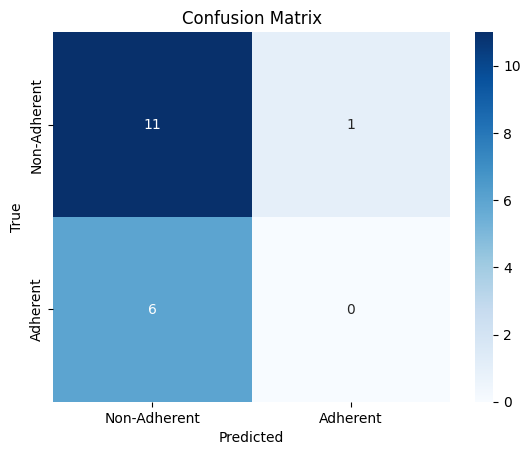

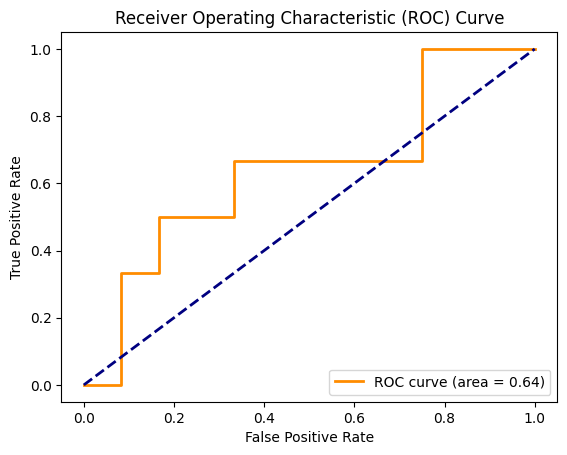

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Test evaluation
best_model.eval()
test_preds, test_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs).squeeze()
        test_preds.extend(outputs.numpy())
        test_true.extend(labels.numpy())

# Convert predictions to binary (0 or 1)
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(test_true, test_preds_binary)
test_f1 = f1_score(test_true, test_preds_binary)
test_precision = precision_score(test_true, test_preds_binary)
test_recall = recall_score(test_true, test_preds_binary)

print("Test Metrics for Best Model:")
print(f"Test Accuracy: {test_accuracy:.4f} | Test F1-Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")

# Calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for param in model.parameters():
        total_params += param.numel()
        zero_params += (param == 0).sum().item()
    sparsity = zero_params / total_params
    return sparsity

sparsity = calculate_sparsity(best_model)
print(f"Sparsity of Best Model: {sparsity:.4f}")

# Generate confusion matrix
cm = confusion_matrix(test_true, test_preds_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Adherent", "Adherent"], yticklabels=["Non-Adherent", "Adherent"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()